# Unsupervised Learning for Dimensionality Reduction and Recommendation Systems

In this tutorial, we will apply unsupervised learning techniques to dimensionality reduction and to recommendation systems.

Upon completion of this tutorial you will know:
    - how to use PCA for dimensionality reduction
    - how to use K-Means clustering to partition data
    - how to use Non-negative Matrix Factorisation for recommender systems

## A. Principle Component Analysis

Principle Component Analysis (PCA) transforms a set of features (attributes) into another set of features (attributes). Normally, we call it a transformation from a feature space to another feature space. In the new space, each feature is called a component and is associated with a value representing the significance of that component.

#### PCA dimensionality reduction for visualising data

Using PCA, we can remove the components with lower significance.  Let's practice with hand-written digit we used in the previous work.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import tensorflow as tf
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()


### Question 01: What is the dimension (number of input features) of this data.

In [2]:
# check the size of the image

# Write a code below to get the number of features
# Hint: use .shape .

# Use "n_f" as the variable to represent the number of input features

# notice that the feature is actually (28 * 28)
# x is a 3-D array n * 28 * 28
# the aim is to convert to n * 784
n_f = x_train.shape[1] * x_train.shape[2]
print(n_f)


784


In [3]:
x_train = np.reshape(x_train,(-1,n_f))
x_test = np.reshape(x_test,(-1,n_f))
# here the -1 indicate the unspecified value, which will be inferred to 1
# since the aim is a 1 * 784 array

print(x_train.shape, x_test.shape)
# aim is (60000, 784) (10000, 784)

(60000, 784) (10000, 784)


As usual, let's us split the data into a training set, a validation set, and a test set.

In [4]:
# Fill the ? to decide how many samples for training, validation and test, respectively.
x_val   = x_train[55000:,:]
y_val   = y_train[55000:]
x_train = x_train[:10000,:]
y_train = y_train[:10000]
# change order? val first
x_test  = x_test[:5000,:]
y_test  = y_test[:5000]
print("Number of sample for train: %d, validation: %d, test: %d"%(x_train.shape[0],x_val.shape[0],x_test.shape[0]))


Number of sample for train: 10000, validation: 5000, test: 5000


##### Question 02: Now, we reduce the dimensionality to 2. Complete the code below (fill the ?).

In [5]:
warnings.filterwarnings('ignore')
from sklearn import decomposition

pca=decomposition.PCA()
pca.n_components = 2
x_train_pca = pca.fit_transform(x_train)

print("The shape of the pca data is: %d x %d"%(x_train_pca.shape[0],x_train_pca.shape[1]))

The shape of the pca data is: 10000 x 2


If your code is working, the below code will visualise the dataset in 2D plot.

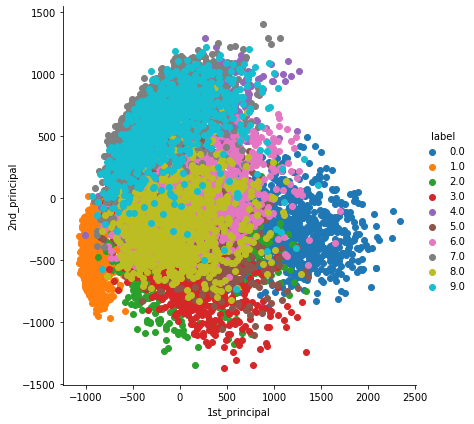

In [6]:
%matplotlib inline

#import the plot2d function
from toolkit import plot2d 

#plot the pca data
plot2d(x_train_pca,y_train)


### PCA dimensionality reduction for fast training

Besides visualisation, dimensionality reduction can also be used to improve the learning speed (and sometime the performance). Of course, using 2 components maybe not a good idea and we need to have an analytical method to choose the number of component. To this end, we unset the number of components allowing the transformation to keep all components and select the most significant components that constitute to $90\%$ or more of the variance percentage. In practice, we can set the percentage from $90\%$ to $99\%$ depending on the data. In the code, this can be done easily by setting the n_components as the desired percentage.

##### Question 03: Fill the ? in the code below to select the most significant components that constitute to  90%  or more of the variance percentage.

In [7]:
pca=decomposition.PCA(n_components=0.9)
pca.fit(x_train)

PCA(n_components=0.9)

If it completes successfully, we can transform the features as follows.

In [8]:
x_train_pca = pca.transform(x_train)
x_val_pca   = pca.transform(x_val)
x_test_pca  = pca.transform(x_test)
print(x_train_pca.shape)

(10000, 85)


Now you can train the models using the new features as usual. With the lower dimensionality we will need less time.

In [9]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit

def grid_search(model, grid_params):
    # Combine the train, and val dataset together
    all_inputs = np.append(x_train_pca,x_val_pca,axis=0)
    all_labels = np.append(y_train,y_val)
    # define the val part in all_inputs is for validation
    val_inds = [-1]*x_train_pca.shape[0] + [0]*x_val_pca.shape[0]
    ps   = PredefinedSplit(test_fold=val_inds)
    # employ Grid Search with cross validation, but now there is only 1 fold with the val part is for validation
    grid = GridSearchCV(model, grid_params,cv=ps, scoring="accuracy",refit = True, verbose = 3,n_jobs=-1) 
   
    # fitting the model for grid search 
    grid.fit(all_inputs, all_labels) 
 
    return grid

##### Question 04: Use the grid search function above, select the best value of "C" for SVC among [1,10,50,100] for the classification task with MNIST.

In [10]:
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

grid_param = {'C': [1, 10, 50, 100]}

grid = grid_search(SVC(), grid_params=grid_param)
pred = grid.predict(x_test_pca)
accuracy = accuracy_score(y_true=y_test, y_pred=pred)

print("Accuracy %.5f" %(accuracy))

Fitting 1 folds for each of 4 candidates, totalling 4 fits
Accuracy 0.95620


## B. Clustering

Now, we apply another unsupervised learning technique known as K-Means clustering to the MNIST data for visualisation. Let's look again at the shape of the data.

In [11]:
print(x_train.shape)
print(y_train.shape)

(10000, 784)
(10000,)


Now, we transform the data into 2 dimension space.

In [12]:
pca.n_components = 2
x_train_pca = pca.fit_transform(x_train)

Using K-Means to group the data into 10 different groups (clusters).

In [13]:
from sklearn.cluster import KMeans
warnings.filterwarnings('ignore')

NCLUSTER = 10 # Number of cluster is equal to the number of class
kmeans = KMeans(init="k-means++", n_clusters=NCLUSTER, n_init=4)
# init: selects initial cluster centroids using sampling based on an 
# empirical probability distribution of the points’ contribution 
# to the overall inertia

# n_init: Number of time the k-means algorithm will be run with different 
# centroid seeds. The final results will be the best output of n_init 
# consecutive runs in terms of inertia.
kmeans.fit(x_train_pca)

KMeans(n_clusters=10, n_init=4)

and visualise

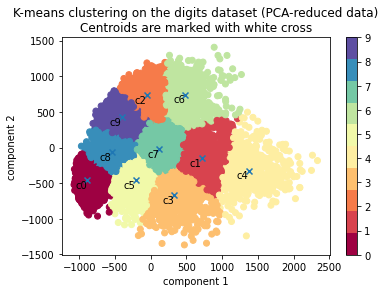

In [14]:
%matplotlib inline
from toolkit import plot_kmeans

plot_kmeans(kmeans,x_train_pca)

## C. Non-Negative Matrix Decomposition for Recommedation Systems

In this exercise, we will apply Non-Negative Matrix Factorisation to build a recommender system. In particular, we will recommend movies to users based on their ratings of other movies.

First, let us load the data using Pandas.

In [15]:
#Somehting is missing here, please fill the line below to make sure we use pandas 
import pandas as pd

# Loading ratings
names = ['user_id', 'item_id', 'rating', 'timestamp']
ratings_df = pd.read_csv('./ml-100k/u.data', sep='\t',encoding = "ISO-8859-1", names=names)

# Loading movies info
item_info = pd.read_csv('./ml-100k/u.item', sep='|', header=None, encoding = "ISO-8859-1", usecols=[1])  

##### Question 05: Print some first entries of the rating data

In [16]:
ratings_df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


If your code is correct, you can see the struture of the data in which each row represents a user_id, an item_id (movie) and the rating of that user for the movie.

##### Question 06: How many ratings does the dataset have?

In [17]:
ratings_df.shape

(100000, 4)

Let us find out the number of users and the numberr of movies (items) in the dataset.

In [18]:
n_users = len(ratings_df['user_id'].unique()) # find number of unique user
n_items = len(ratings_df['item_id'].unique())
R_shape = (n_users, n_items)
print(str(n_users) + ' users')
print(str(n_items) + ' items')

943 users
1682 items


Run the code below to visualise the distribution of rating.

Text(0.5, 1.0, 'Distribution of ratings')

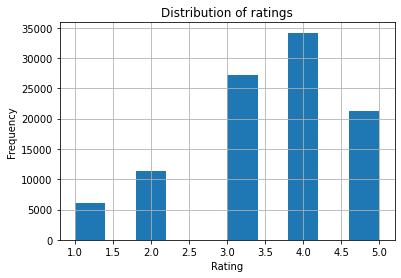

In [19]:
import matplotlib.pyplot as plt
ratings_df['rating'].hist(grid=True)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of ratings')

##### Question 07: Which rating is the most frequent?

The item_info data frame consists the information of the movies. 

##### Question 08: Show some first movies in item_info?

In [20]:
item_info.head()

,1
0,Toy Story (1995)
1,GoldenEye (1995)
2,Four Rooms (1995)
3,Get Shorty (1995)
4,Copycat (1995)


To build a NMF for the task, we will get the pairs of user-item as X and the rating as y.

In [21]:
X = ratings_df[['user_id', 'item_id']].values # n * 2
y = ratings_df['rating'].values # 1 * n

As we know that NMF will work on a matrix, we will need to construct a matrix where each row represent a user and each column represents a movie. A value in a cell of the matrix is the rating of the movie (col) from the user (row). The code below prints the shape of the matrix.

In [22]:
R_shape = (n_users, n_items)
print(R_shape)

(943, 1682)


We will convert the data (from X and y) to the matrix usig the ConvertToDense function.

In [23]:
from toolkit import ConvertToDense

# sparse.csr_matrix((data,(row,col)), shape=(shape[0]+1,shape[1]+1))
# here +1 since python starts from 0, and we need 1 more row/column
# row(X)->col(y) is data(rating), this will gives you somthing in order
# (1, 1)	5
# (1, 2)	3 etc.

# matrix_sparse.todense() would transform csr matrix to matrix based on index
# R[1:,1:]  eliminate the extra row/column
# then transform to array  

R = ConvertToDense(X, y, R_shape)       


If you print the shape of the matrix, it will be the same as R_shape

In [24]:
print(R.shape)

(943, 1682)


##### Question 09: What is the value in R for the user at index 1 and item (movie) at index 5?

In [25]:
print(R[1, 5]) # is 0
R

0


array([[5, 3, 4, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 5, 0, ..., 0, 0, 0]], dtype=int64)

##### Question 10: What does the rating tells?

Now, to warm up with NMF, we apply NMF to the whole dataset. NMF decompose the rating matrix R into a user factor matrix W and an item factor matrix H. For an example we use the number of components as 5.

In [26]:
from sklearn.decomposition import NMF
import time
start_time = time.time()
nmf_model = NMF(n_components=100)  # (943*5 for W and 5*1682 for H) 
 
nmf_model.fit(R)                     
W = nmf_model.transform(R)         # user factor matrix
H = nmf_model.components_          # item latent factor matrix

elapse_time = time.time() - start_time
print(elapse_time)
print(W.shape)
print(H.shape)

6.813668966293335
(943, 100)
(100, 1682)


To predict the missing rating (value 0s in the rating matrix), we reconstruct the rating matrix from user factor matrix and item factor matrix.

In [27]:
# Reconstruction
R_pred = np.matmul(W,H)

##### Question 11: What is the predicted rating of the user at index 1 and item (movie) at index 5?

In [28]:
R_pred[1, 5]

0.21278734103576033

##### Question 12: To measure difference between the reconstructed rating matrix and the original one we use mean squared error to calculate. Fill the code below to get the mean square error

In [29]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_true=R, y_pred=R_pred)
print(mse)

0.3236738711201976


##### Question 13: Use different values for the number of components and show the correlations between those values and the mean square errors, and also between those values and the time needed for the factorisation.

In [30]:
#HINT: Run the code sections above multiple times with incremental 
#values of the number of components and record the time and the mse

num_components = [5,10,20,50,100]
mses =[0.52, 0.48, 0.44, 0.39, 0.32]
times = [0.50, 0.67, 1.16, 2.70, 6.81]

Use the code below to plot the correlations.

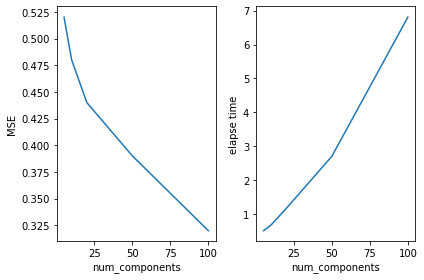

In [31]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=2)
plt.subplot(1,2,1)
plt.plot(num_components,mses)
plt.xlabel("num_components")
plt.ylabel("MSE")

plt.subplot(1,2,2)
plt.plot(num_components,times)
plt.xlabel("num_components")
plt.ylabel("elapse time")

fig.tight_layout()

##### Question 14: Can we use the predicted ratings for recommendation? Why?



the performance here compares no value(rating 0) often, so the mse is meaningless. We want to split it up, and compare real value to pred to see perfomance

As usual, the best way is to select the the number of components is using model selection. Let define a cross validation function.

In [32]:
from sklearn.model_selection import KFold
def cross_val(model,X,y,error_func,nfolds=5):
    err = 0
    kfold = KFold(n_splits=nfolds)
    for train_index, test_index in kfold.split(X):   
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        R_train = ConvertToDense(X_train, y_train, R_shape)
        R_test = ConvertToDense(X_test, y_test, R_shape)

        # Here R_test contains more ratings

        model.fit(R_train)  
        W = model.transform(R_train)       
        H = model.components_                

        # Making the predictions
        R_pred = np.matmul(W,H)    
    
        # Clipping values                                                    
        R_pred[R_pred > 5] = 5.           # clips ratings above 5             
        R_pred[R_pred < 1] = 1.           # clips ratings below 1

        # Computing the error 
        err += error_func(R_pred,R_test)

    return err

Note that in the cross_val function, we use a error_func to compute the error of prediction. We can't use the MSE in the question 10 directly, instead we need to use the following function.

In [33]:
#mse for recommender system
def rs_mse(R_pred,R_test):
    mask = (R_test>0) * 1
    # R_pred is close to R_train, but contains less info
    # than R_test, 
     
    # print("pred")
    # print(R_pred)
    # print("test")
    # print(R_test)
    # print("add mask")
    # print(R_pred*mask)
    
    mse = mean_squared_error(R_pred * mask, R_test)

    return mse

# here the mask basically means if test data has not 
# have a rating (0), then just leave the pred also no 
# rating, and leave the pred as it is if test has rate

# notice that it's using the train (WH) to pred, and 
# mse is using for compare pred and test 

##### Question 15* : Why we need  mask in the above code? <br>


Now, apply grid search to the number of components. We define a grid of parameters first.

In [34]:
param_grid = {'n_components' : [5, 10, 15, 20, 25]}

and perform a loop to search for the best value of n_components.

In [35]:
import warnings
warnings.filterwarnings('ignore')

mses = []
min_mse = 10000000
for n_comp in param_grid['n_components']:
    nmf = NMF(n_components = n_comp)
    mse = cross_val(nmf,X,y,error_func=rs_mse)
    mses.append(mse)
    if mse<min_mse:
        min_mse = mse

Generate a plot of the correlation between number of the components and the mean square error.

Text(0, 0.5, 'MSE')

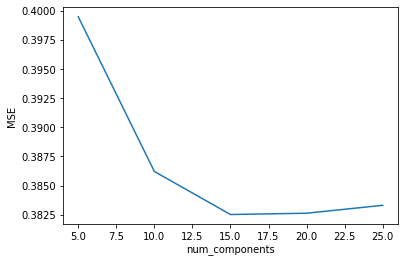

In [36]:
plt.plot(param_grid['n_components'],mses)
plt.xlabel("num_components")
plt.ylabel("MSE")

Now, after selecting the best number of componennt, we can apply to the whole dataset to predict the rating.

In [39]:
# Now apply to 
nmf_model = NMF(n_components=15)     
nmf_model.fit(R)  
W = nmf_model.transform(R)       # user latent factors (= W, called the features matrix)
H = nmf_model.components_          # item latent factors (= H.T) (H is called the coefficient matrix)
R_pred = np.matmul(W,H)

and make recommendation.

In [40]:
import pandas as pd
def make_recommendation_activeuser(R, prediction, user_idx, k=5):
    #k  ............ number of movies to recommend
    
    rated_items_df_user = pd.DataFrame(R).iloc[user_idx, :]  
    # print(rated_items_df_user)               # get the list of actual ratings of user_idx (seen movies)
    user_prediction_df_user = pd.DataFrame(prediction).iloc[user_idx,:]     # get the list of predicted ratings of user_idx (unseen movies)
    reco_df = pd.concat([rated_items_df_user, user_prediction_df_user, item_info], axis=1)  
    # print(reco_df) # merge both lists with the movie's title
    reco_df.columns = ['rating','prediction','title']

    print('Preferred movies for user %d'%(user_idx))
    print(reco_df.sort_values(by='rating', ascending=False)[:k])             # returns k seen movies with the best actual ratings
    print('Recommended movies for user %d'%(user_idx))
    reco_df = reco_df[ reco_df['rating'] == 0 ]
    print(reco_df.sort_values(by='prediction', ascending=False)[:k])         # returns k unseen movies with the best predicted ratings
  
make_recommendation_activeuser(R, R_pred, user_idx=50, k=5)
make_recommendation_activeuser(R, R_pred, user_idx=130, k=5)

Preferred movies for user 50
     rating  prediction                            title
171       5    1.133113  Empire Strikes Back, The (1980)
180       5    2.161858        Return of the Jedi (1983)
172       5    0.807389       Princess Bride, The (1987)
49        5    2.485380                 Star Wars (1977)
143       5    0.515385                  Die Hard (1988)
Recommended movies for user 50
     rating  prediction                           title
173       0    1.322388  Raiders of the Lost Ark (1981)
256       0    1.250253             Men in Black (1997)
0         0    1.237878                Toy Story (1995)
126       0    1.195078           Godfather, The (1972)
257       0    1.029138                  Contact (1997)
Preferred movies for user 130
     rating  prediction                        title
285       5    4.302325  English Patient, The (1996)
312       5    0.579597               Titanic (1997)
535       5    0.158639               Ponette (1996)
99        5    4.301